In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
data = pd.read_csv('data/filter_data.csv')
hurst_estimates = pd.read_csv('data/hurst_estimates.csv')
hurst_estimates.set_index('Unnamed: 0', inplace=True)

In [18]:
from AutoValidator.model_tester import ModelTester
from AutoValidator.ErrorMetrics import calculate_all_errors

## Random Walk on each dataset

In [19]:
class RandomWalk():
    
    def __init__(self, horizon):
        self.horizon = horizon
    
    def fit(self, train, labels):
        self.train = labels
    
    def predict(self, data):
        comb_data = np.hstack([self.train, data])
        
        results = np.zeros((len(data), self.horizon))
        
        std = np.std(comb_data)
        
        results[:, 0] = data[:]
        
        noise = np.random.normal(0, std, (len(data), self.horizon))
        results += noise        
        
        return results.cumsum(axis=1)
    
    def __repr__(self):
        return 'Random Walk'

In [20]:
walk = RandomWalk(5)

In [21]:
d = np.arange(0, 100)

In [22]:
walk.fit(d[:80], d[:80])

In [23]:
a = walk.predict(d[80:])

In [24]:
a

array([[ 96.04640567,  91.72972055, 117.64088396, 161.36261199,
        178.96225051],
       [ 46.45234249,  19.0070421 ,  68.07902147,  50.17433791,
         62.81756452],
       [ 73.90700728, 127.39418732, 136.89357401, 113.33797336,
        113.84504175],
       [ 67.12810391,  43.87073975,  15.70693039,  22.05649337,
         36.44528022],
       [ 88.96373709,  78.57889915,  40.60446367, -15.00713111,
         23.72124189],
       [ 55.56674268,  -8.41928806, -36.28391784, -59.33249375,
        -49.70322319],
       [108.29033513, 141.67635313, 104.75702713, 102.69410309,
         56.33621149],
       [ 90.01247348,  75.50099371,  86.39074974, 104.8262943 ,
         74.08602361],
       [114.49027826,  62.39314325,  50.53041876,  35.28034763,
         26.50860252],
       [ 47.99995259,  28.06282074,  33.01188679,  54.20558492,
         34.38054155],
       [ 85.66879606,  75.92496615,  60.65147234,  58.15919253,
         71.29045171],
       [116.85945429,  53.78411764,   3.664

<IPython.core.display.Javascript object>


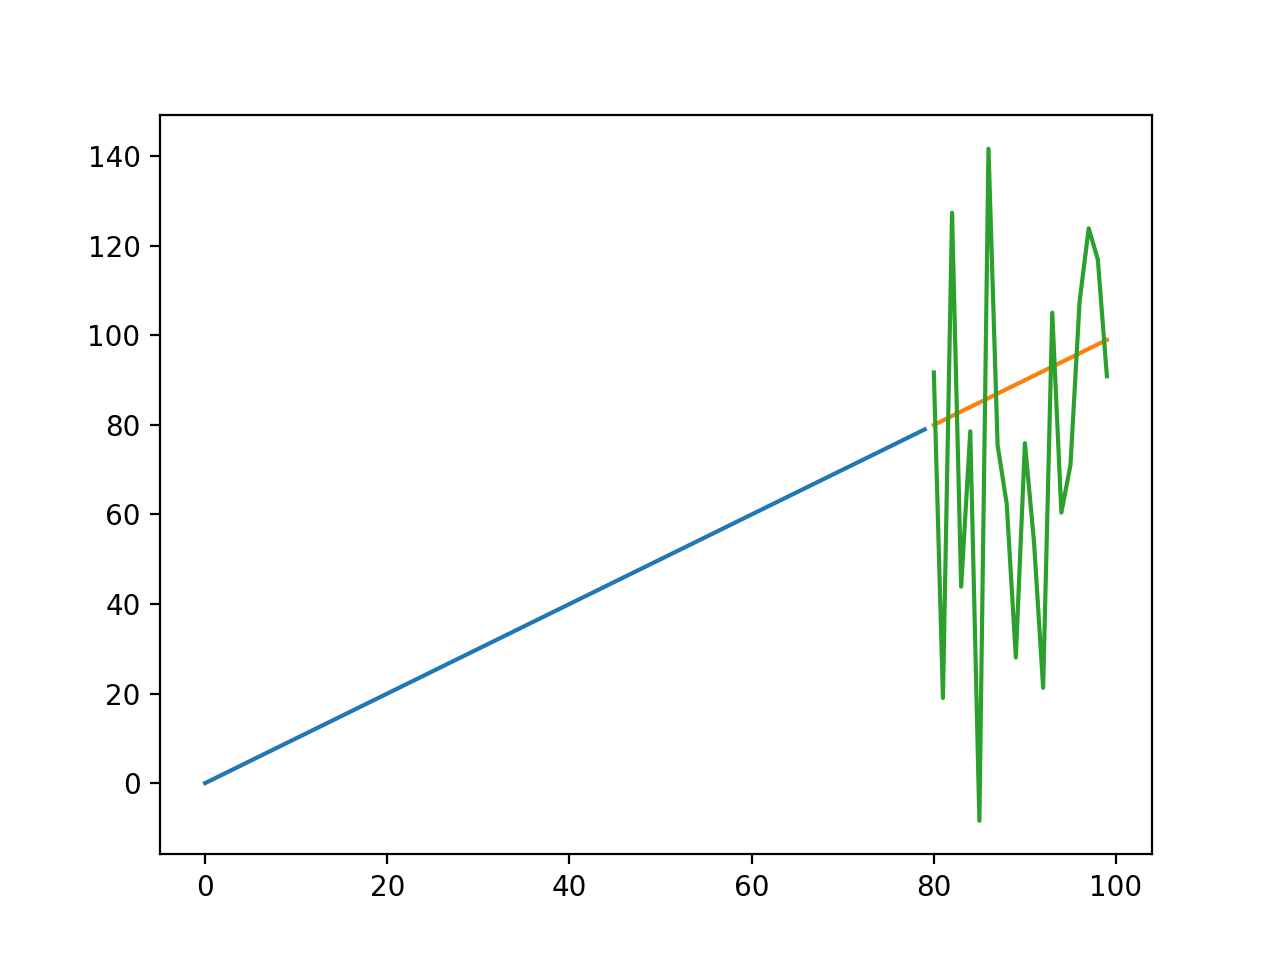

In [25]:
%matplotlib notebook
plt.plot(np.arange(80), d[:80])
plt.plot(np.arange(80, 100), d[80:])
plt.plot(np.arange(80, 100), a[:, 1])

## Mean estimation

In [26]:
class MeanEstimator():
    
    def __init__(self, horizon):
        self.horizon = horizon
        
    def fit(self, train, labels):
        self.train = labels
    
    def predict(self, data):
        return np.repeat( pd.Series(np.hstack([self.train, data])).expanding().mean()[len(self.train):], self.horizon).values.reshape(len(data), self.horizon)    

    def __repr__(self):
        return 'Mean Estimator'

In [27]:
me = MeanEstimator(5)

In [28]:
d = np.arange(0, 100)

In [29]:
me.fit(d[:80], d[:80])

In [30]:
a = me.predict(d[80:])

In [31]:
a

array([[40. , 40. , 40. , 40. , 40. ],
       [40.5, 40.5, 40.5, 40.5, 40.5],
       [41. , 41. , 41. , 41. , 41. ],
       [41.5, 41.5, 41.5, 41.5, 41.5],
       [42. , 42. , 42. , 42. , 42. ],
       [42.5, 42.5, 42.5, 42.5, 42.5],
       [43. , 43. , 43. , 43. , 43. ],
       [43.5, 43.5, 43.5, 43.5, 43.5],
       [44. , 44. , 44. , 44. , 44. ],
       [44.5, 44.5, 44.5, 44.5, 44.5],
       [45. , 45. , 45. , 45. , 45. ],
       [45.5, 45.5, 45.5, 45.5, 45.5],
       [46. , 46. , 46. , 46. , 46. ],
       [46.5, 46.5, 46.5, 46.5, 46.5],
       [47. , 47. , 47. , 47. , 47. ],
       [47.5, 47.5, 47.5, 47.5, 47.5],
       [48. , 48. , 48. , 48. , 48. ],
       [48.5, 48.5, 48.5, 48.5, 48.5],
       [49. , 49. , 49. , 49. , 49. ],
       [49.5, 49.5, 49.5, 49.5, 49.5]])

## Moving Average Estimator

In [34]:
class MovingAvgEstimator():
    
    def __init__(self, horizon, back_horizon=None):
        self.horizon = horizon
        
        if back_horizon is None:
            back_horizon = horizon
        self.back_horizon = back_horizon
        
    def fit(self, train, labels):
        self.starting_horizon = labels[-(self.back_horizon - 1):]
        
    def predict(self, data):
        comb_data = np.hstack([self.starting_horizon, data])
        
        return np.repeat(pd.Series(comb_data).rolling(self.back_horizon).mean().dropna(axis=0).values, self.horizon).reshape(len(data), self.horizon)
    
    def __repr__(self):
        return 'Moving Avg Estimator: (h={:d})'.format(self.horizon)

## MVA test

In [35]:
mva = MovingAvgEstimator(5, 60)

In [36]:
d = np.arange(0, 100)

In [37]:
d[80:]

array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
       97, 98, 99])

In [38]:
mva.fit(d[:80], d[:80])

In [39]:
a = mva.predict(d[80:])

In [40]:
a

array([[50.5, 50.5, 50.5, 50.5, 50.5],
       [51.5, 51.5, 51.5, 51.5, 51.5],
       [52.5, 52.5, 52.5, 52.5, 52.5],
       [53.5, 53.5, 53.5, 53.5, 53.5],
       [54.5, 54.5, 54.5, 54.5, 54.5],
       [55.5, 55.5, 55.5, 55.5, 55.5],
       [56.5, 56.5, 56.5, 56.5, 56.5],
       [57.5, 57.5, 57.5, 57.5, 57.5],
       [58.5, 58.5, 58.5, 58.5, 58.5],
       [59.5, 59.5, 59.5, 59.5, 59.5],
       [60.5, 60.5, 60.5, 60.5, 60.5],
       [61.5, 61.5, 61.5, 61.5, 61.5],
       [62.5, 62.5, 62.5, 62.5, 62.5],
       [63.5, 63.5, 63.5, 63.5, 63.5],
       [64.5, 64.5, 64.5, 64.5, 64.5],
       [65.5, 65.5, 65.5, 65.5, 65.5],
       [66.5, 66.5, 66.5, 66.5, 66.5],
       [67.5, 67.5, 67.5, 67.5, 67.5],
       [68.5, 68.5, 68.5, 68.5, 68.5],
       [69.5, 69.5, 69.5, 69.5, 69.5]])

## 1 minute horizon

In [41]:
horizon = 1

walk = RandomWalk(horizon)
mean = MeanEstimator(horizon)
mva = MovingAvgEstimator(horizon, 15)

In [42]:
one_min_tester = ModelTester(data, horizon, 0.20)

# one_min_tester.add_model(walk)
# one_min_tester.add_model(mean)
# one_min_tester.add_model(mva)

In [43]:
# results = one_min_tester.test_models()

# Loading bar
one_min_tester.progressBar.set_length(3 * len(data.columns))

# walk speed up
one_min_tester.results[repr(walk)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    walk.fit(train, train)
    pred = walk.predict(test)
    
    one_min_tester.results[repr(walk)][column] = pred
    one_min_tester.progressBar.progress()

# Mean speed up
one_min_tester.results[repr(mean)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mean.fit(train, train)
    pred = mean.predict(test)
    
    one_min_tester.results[repr(mean)][column] = pred
    one_min_tester.progressBar.progress()
    
# MVA speed up
one_min_tester.results[repr(mva)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mva.fit(train, train)
    pred = mva.predict(test)
    
    one_min_tester.results[repr(mva)][column] = pred
    one_min_tester.progressBar.progress()
    
    
one_min_tester.add_model(walk)
one_min_tester.add_model(mean)
one_min_tester.add_model(mva)

Progress: [####################] 100.0%


In [259]:
one_min_errors = one_min_tester.evaluate_model([repr(walk), repr(mean), repr(mva)])

Progress: [####################] 100.0%


In [260]:
one_min_errors.head()

,Random Walk_RMSE,Random Walk_MASE,Mean Estimator_RMSE,Mean Estimator_MASE,Moving Avg Estimator: (h=1)_RMSE,Moving Avg Estimator: (h=1)_MASE,RMSE avg,RMSE std,MASE avg,MASE std
window_1_0,370.533968,1.004252,383.837483,1.000144,163.039179,0.210079,305.803544,123.816371,0.738158,0.457335
window_1_1,379.806208,1.014568,396.917204,0.999950,203.608563,0.231355,326.777325,107.009834,0.748624,0.448028
window_1_2,430.624012,1.055514,427.997371,0.999772,231.324784,0.292538,363.315389,114.314761,0.782608,0.425328
window_1_3,482.762616,1.000951,474.148053,0.999513,243.012425,0.263358,399.974365,136.001252,0.754607,0.425435
window_1_4,418.734964,1.158180,414.860941,0.999991,269.804186,0.390564,367.800030,84.888993,0.849578,0.405310


In [261]:
one_min_errors.to_csv('results/one_minute_baseline_results.csv')

Progress: [####################] 100.0%


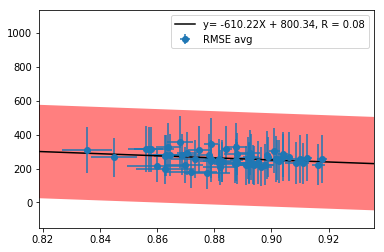

In [263]:
one_min_tester.compare_hurst(hurst_estimates)

## 5 minute horizon

In [244]:
horizon = 5

walk = RandomWalk(horizon)
mean = MeanEstimator(horizon)
mva = MovingAvgEstimator(horizon, 30)

In [245]:
five_min_tester = ModelTester(data, horizon, 0.20)

# five_min_tester.add_model(walk)
# five_min_tester.add_model(mean)
# five_min_tester.add_model(mva)

In [247]:
# results = five_min_tester.test_models()

# Loading bar
five_min_tester.progressBar.set_length(3 * len(data.columns))

# walk speed up
five_min_tester.results[repr(walk)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    walk.fit(train, train)
    pred = walk.predict(test)
    
    five_min_tester.results[repr(walk)][column] = pred
    five_min_tester.progressBar.progress()

# Mean speed up
five_min_tester.results[repr(mean)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mean.fit(train, train)
    pred = mean.predict(test)
    
    five_min_tester.results[repr(mean)][column] = pred
    five_min_tester.progressBar.progress()
    
# MVA speed up
five_min_tester.results[repr(mva)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mva.fit(train, train)
    pred = mva.predict(test)
    
    five_min_tester.results[repr(mva)][column] = pred
    five_min_tester.progressBar.progress()
    
    
five_min_tester.add_model(walk)
five_min_tester.add_model(mean)
five_min_tester.add_model(mva)


Progress: [####################] 100.0%


In [248]:
errors = five_min_tester.evaluate_model([repr(walk), repr(mean), repr(mva)])

Progress: [####################] 100.0%


In [249]:
errors.head()

,Random Walk_RMSE,Random Walk_MASE,Mean Estimator_RMSE,Mean Estimator_MASE,Moving Avg Estimator: (h=5)_RMSE,Moving Avg Estimator: (h=5)_MASE,RMSE avg,RMSE std,MASE avg,MASE std
window_1_0,661.263658,1.727968,383.861537,1.000191,208.020821,0.312315,417.715339,228.510016,1.013492,0.707920
window_1_1,679.470486,1.742633,396.939533,0.999996,251.951506,0.332516,442.787175,217.415787,1.025049,0.705392
window_1_2,775.806363,1.828303,428.017916,0.999817,286.065923,0.400614,496.630068,251.976477,1.076245,0.716906
window_1_3,857.250337,1.713267,474.160543,0.999559,298.229288,0.361694,543.213389,285.836238,1.024840,0.676141
window_1_4,757.849641,2.009544,414.865606,1.000035,327.760376,0.526636,500.158541,227.377126,1.178738,0.757433


In [250]:
errors.to_csv('results/baseline_five_minutes_results.cssv')

Progress: [####################] 100.0%


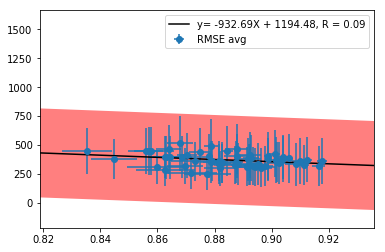

In [251]:
five_min_tester.compare_hurst(hurst_estimates)

## 60 minute horizon

In [273]:
horizon = 60

walk = RandomWalk(horizon)
mean = MeanEstimator(horizon)
mva = MovingAvgEstimator(horizon, 15)

In [274]:
sixty_min_tester = ModelTester(data, horizon, 0.20)

# sixty_min_tester.add_model(walk)
# sixty_min_tester.add_model(mean)
# sixty_min_tester.add_model(mva)

In [275]:
# results = sixty_min_tester.test_models()

# Loading bar
sixty_min_tester.progressBar.set_length(3 * len(data.columns))

# walk speed up
sixty_min_tester.results[repr(walk)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    walk.fit(train, train)
    pred = walk.predict(test)
    
    sixty_min_tester.results[repr(walk)][column] = pred
    sixty_min_tester.progressBar.progress()

# Mean speed up
sixty_min_tester.results[repr(mean)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mean.fit(train, train)
    pred = mean.predict(test)
    
    sixty_min_tester.results[repr(mean)][column] = pred
    sixty_min_tester.progressBar.progress()
    
# MVA speed up
sixty_min_tester.results[repr(mva)] = {}

for i, column in enumerate(data.columns):
    split = int(0.20 * len(data))
    train, test = data[column][:split], data[column][split:]
    test = test[:len(test) - len(test) % horizon]
    mva.fit(train, train)
    pred = mva.predict(test)
    
    sixty_min_tester.results[repr(mva)][column] = pred
    sixty_min_tester.progressBar.progress()
    
    
sixty_min_tester.add_model(walk)
sixty_min_tester.add_model(mean)
sixty_min_tester.add_model(mva)

Progress: [####################] 100.0%


In [276]:
sixty_min_errors = sixty_min_tester.evaluate_model([repr(walk), repr(mean), repr(mva)])

Progress: [####################] 100.0%


In [277]:
sixty_min_errors.head()

,Random Walk_RMSE,Random Walk_MASE,Mean Estimator_RMSE,Mean Estimator_MASE,Moving Avg Estimator: (h=60)_RMSE,Moving Avg Estimator: (h=60)_MASE,RMSE avg,RMSE std,MASE avg,MASE std
window_1_0,2065.975932,5.322430,384.073938,1.000736,278.989790,0.474663,909.679887,1002.759232,2.265943,2.660033
window_1_1,2147.844412,5.452250,397.132707,1.000513,328.530664,0.478586,957.835928,1031.148246,2.310450,2.733365
window_1_2,2357.930876,5.457775,428.186035,1.000261,375.524678,0.564759,1053.880530,1129.647637,2.340932,2.708034
window_1_3,2721.066358,5.349110,474.332294,1.000025,384.617480,0.502252,1193.338711,1323.811169,2.283796,2.666282
window_1_4,2320.248875,6.061397,414.946261,1.000384,408.395873,0.703408,1047.863670,1101.922779,2.588396,3.011370


In [270]:
sixty_min_errors.to_csv('results/sixty_minute_baseline_results.csv')

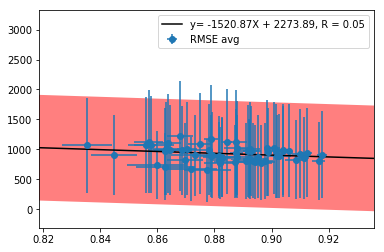

In [271]:
sixty_min_tester.compare_hurst(hurst_estimates, errors=sixty_min_errors)

<IPython.core.display.Javascript object>


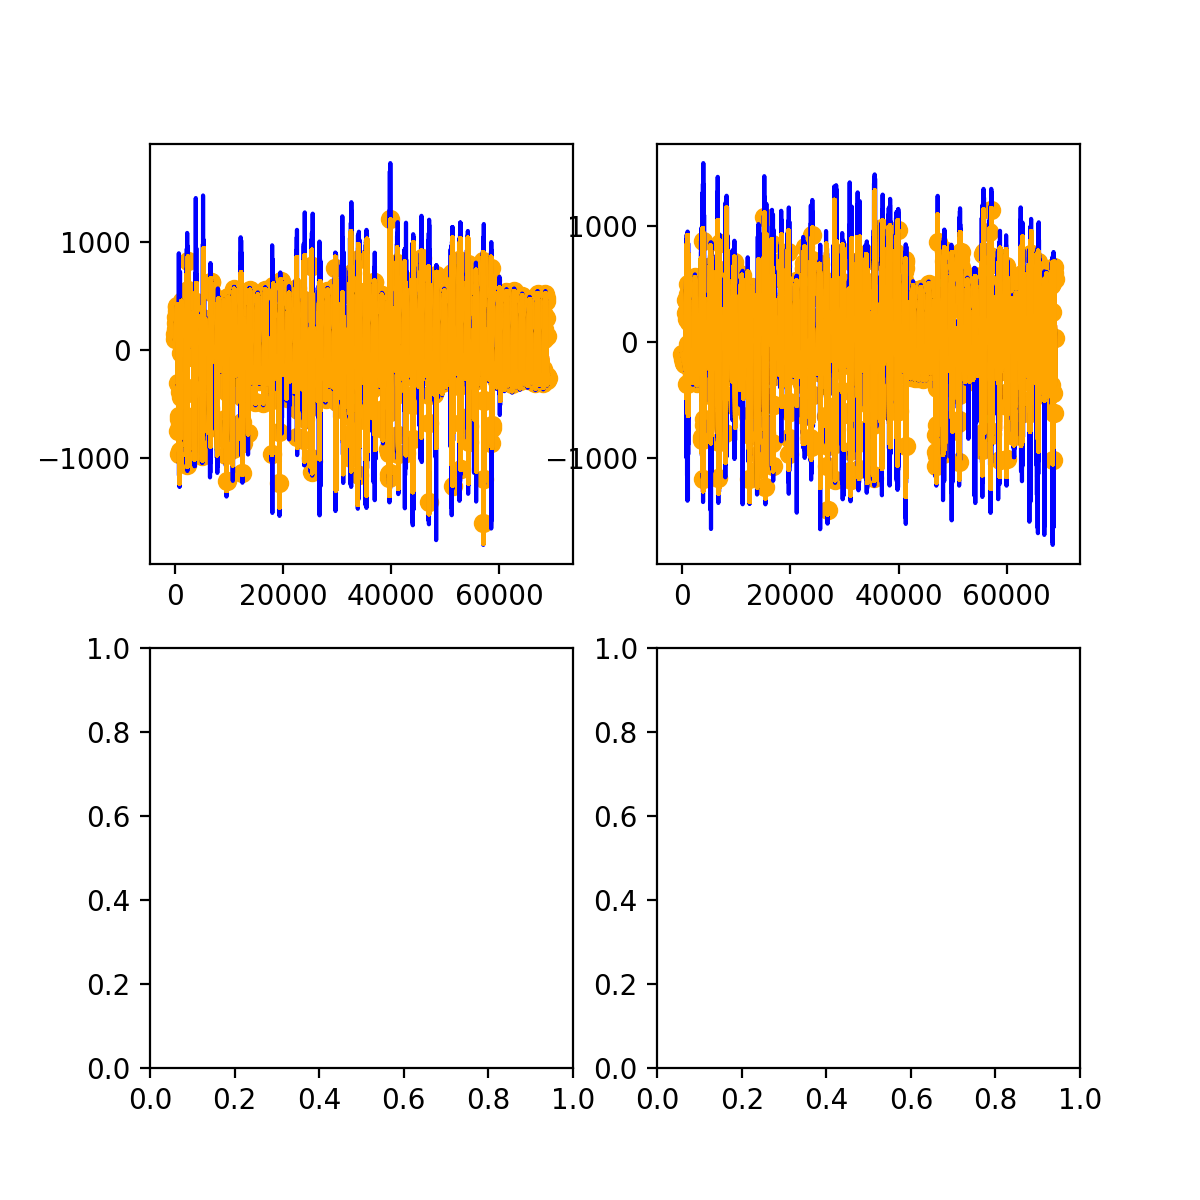

In [304]:
%matplotlib notebook
sixty_min_tester.visualise_result(repr(mva), [1, 2], figsize=(6, 6))